# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [177]:
# Import packeges  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pydst

# Define Danish Statistics API as dst 
dst = pydst.Dst(lang='en')

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Plotting style 
plt.style.use('seaborn-whitegrid')

# user written modules
# import dataproject


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

We want to look at gender equality when it comes to parental leave share and education level in Denmark. To do so we look at BARSEL05 from Danish Statistics and on parents which both are entitled to "barsels dagpenge". 

We get all the subjects of Danish Statistics and looking op BARSEL05 at the DST webpage we see that we want "Social conditions" which is the 4th id. 

In [178]:
dst.get_subjects()

,id,desc,active,hasSubjects
0,1,People,True,True
1,2,Labour and income,True,True
2,3,Economy,True,True
3,4,Social conditions,True,True
4,5,Education and research,True,True
5,6,Business,True,True
6,7,Transport,True,True
7,8,Culture and leisure,True,True
8,9,Environment and energy,True,True
9,19,Other,True,True


We extract the table with all element for "Social conditions" and further look at BARSEL05

In [179]:
tables = dst.get_tables(subjects=['4'])
tables[tables.id == 'BARSEL05']

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
30,BARSEL05,Cohabiting parents leave before birth and in t...,Days,2022-05-30 08:00:00,2015,2020,True,"[unit, entitlement, mothers education, fathers..."


Then we look at the variables for BARSEL05. 

We see that it contains TAL, BERET, MORUD, FARUD and Tid. 
TAL is .... 
BERET is if which or both parents are entitled to "barsels dagpenge". 
MORUD is the education level for the mother. 
FARUD is the education level for the father. 
OMRÅDE is region and Tid is the years of observation. 

In [180]:
indk_vars = dst.get_variables(table_id='BARSEL05')
indk_vars

,id,text,elimination,time,values,map
0,TAL,unit,False,False,"[{'id': '000', 'text': 'Number of couples'}, {...",NaN
1,BERET,entitlement,False,False,"[{'id': '003', 'text': 'All parents (couples),...",NaN
2,MORUD,mothers education,False,False,"[{'id': '002', 'text': 'All mothers, regardles...",NaN
3,FARUD,fathers education,False,False,"[{'id': '004', 'text': 'All fathers, regardles...",NaN
4,OMRÅDE,region,True,False,"[{'id': '000', 'text': 'All Denmark'}, {'id': ...",denmark_municipality_07
5,Tid,time,False,True,"[{'id': '2015', 'text': '2015'}, {'id': '2016'...",NaN


Futher, we want to see the values of each id. This is elaborated in the following code: 

In [181]:
# a. Loop over the ids 
for id in ['TAL','BERET','MORUD','FARUD','OMRÅDE','Tid']:
    # i. Print the ids
    print(id)
    # ii. Find the id and text for each id 
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    # iii. Print all the values for each id 
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

TAL
 id = 000, text = Number of couples
 id = 110, text = Child - Number of days with at least one parent on benefits
 id = 120, text = Child - Number of days between parents' first and last day on benefits
 id = 200, text = Mother - total days on parental leave (benefits) on average
 id = 202, text = Mother - days on parental leave (benefits) before birth on average
 id = 220, text = Mother - days on parental leave (benefits) after birth on average
 id = 330, text = Father - days on parental leave (benefits) after birth on average
 id = 400, text = Mother -total days of salary during parental leave on average
 id = 404, text = Mother -days of salary during parental leave before birth on average
 id = 440, text = Mother -days of salary during parental leave after birth on average
 id = 550, text = Father - days of salary during parental leave after birth on average
 id = 600, text = Mother - total days without salary during parental leave on average
 id = 606, text = Mother -days witho

For TAL we want to look at "Number of couples", "Mother - days on parental leave (benefits) before birth on average", "Mother - days on parental leave (benefits) after birth on average" and "Father - days on parental leave (benefits) after birth on average", so we pic the ids 000, 202, 220 and 330. 

For BERET we want "Both mother and father are entitled to parental leave". 

For MORUD and FARUD we want all education levels and for Tid we want all obervation years. 

For OMRÅDE we want "All Denmark" so we pic id 000. 


In [182]:
# Load the data
barsel = dst.get_data(table_id = 'BARSEL05', variables={'TAL':['000','202','220','330'], 'BERET':['511'], 'MORUD':['*'], 'FARUD':['*'], 'OMRÅDE':['000'], 'Tid':['*']})
barsel

,TAL,BERET,MORUD,FARUD,OMRÅDE,TID,INDHOLD
0,Number of couples,Both mother and father are entitled to parenta...,"All mothers, regardless of education","All fathers, regardless of education",All Denmark,2015,38611.0
1,Number of couples,Both mother and father are entitled to parenta...,"All mothers, regardless of education",Father lower secondary,All Denmark,2015,3791.0
2,Number of couples,Both mother and father are entitled to parenta...,"All mothers, regardless of education",Father upper secondary,All Denmark,2015,16720.0
3,Number of couples,Both mother and father are entitled to parenta...,"All mothers, regardless of education",Father short cycle tertiary,All Denmark,2015,3002.0
4,Number of couples,Both mother and father are entitled to parenta...,"All mothers, regardless of education",Father bachelor,All Denmark,2015,6886.0
...,...,...,...,...,...,...,...
859,Father - days on parental leave (benefits) aft...,Both mother and father are entitled to parenta...,Mother master,Father lower secondary,All Denmark,2020,31.3
860,Father - days on parental leave (benefits) aft...,Both mother and father are entitled to parenta...,Mother master,Father upper secondary,All Denmark,2020,35.4
861,Father - days on parental leave (benefits) aft...,Both mother and father are entitled to parenta...,Mother master,Father short cycle tertiary,All Denmark,2020,42.2
862,Father - days on parental leave (benefits) aft...,Both mother and father are entitled to parenta...,Mother master,Father bachelor,All Denmark,2020,47.9


In [183]:
# a. Copy 'barsel' to have the original 
barsel_true = barsel.copy()
# b. Sets TID as an integer 
barsel_true['TID'] = barsel_true['TID'].astype(int)
# c. Sets INDHOLD as a float 
barsel_true['INDHOLD'] = barsel_true['INDHOLD'].astype(float)

We wants to look the average days of parential leave for mother and father. Thus, we extract "All fathers, regardless of education" for FARUD, "All mothers, regardless of education" for MORUD and "Mother - days on parental leave (benefits) after birth on average" for TAL for mother and "Father - days on parental leave (benefits) after birth on average" for TAL for father. 

We save the values for the mother in 'Mother_all' and for the father in 'Father_all'. We cut both datasets such it only contains TID and INDHOLD. 

In [184]:
# a. Extract varaibles for mother 
Mother_all = barsel_true[(barsel_true['FARUD'] == 'All fathers, regardless of education') 
                          & (barsel_true['MORUD'] == 'All mothers, regardless of education') 
                          & (barsel_true['TAL'] == 'Mother - days on parental leave (benefits) after birth on average') ]
# b. Cut data 
Mother_all = Mother_all[['TID', 'INDHOLD']]

# c. Extract varaibles for father 
Father_all = barsel_true[(barsel_true['MORUD'] == 'All mothers, regardless of education') 
                          & (barsel_true['FARUD'] == 'All fathers, regardless of education') 
                          & (barsel_true['TAL'] == 'Father - days on parental leave (benefits) after birth on average') ]
# d. Cut data 
Father_all = Father_all[['TID', 'INDHOLD']]

Then we want to plot the two datasets against each other. 

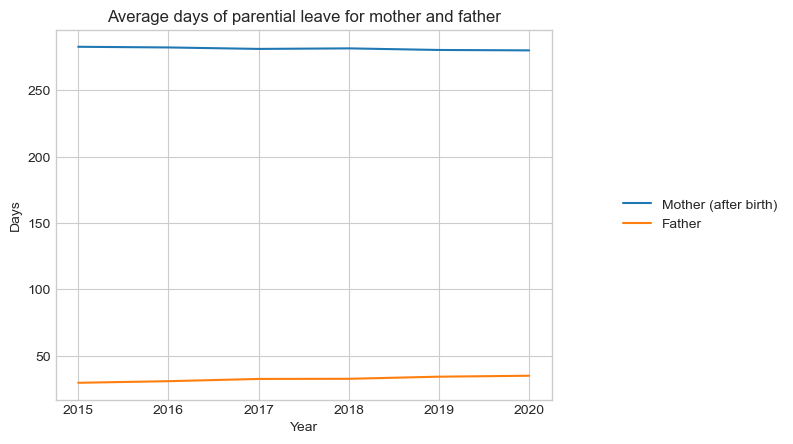

In [185]:
# a. Define the figure and ax 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# b. Plot mother 
Mother_all.plot(x = 'TID', y = 'INDHOLD', ax=ax, label = 'Mother (after birth)')
# c. Plot father 
Father_all.plot(x = 'TID', y = 'INDHOLD', ax=ax, label = 'Father')
# d. Add title, axis labels and legend 
ax.set_title('Average days of parential leave for mother and father')
ax.set_ylabel('Days')
ax.set_xlabel('Year')
ax.legend(loc = 'center', bbox_to_anchor=(1.3,0.5))

From the above we see that the average days for the mother after the birth as a bit decreasing from 282,8 in 2015 to 280,1 in 2020. For the father the average days of parential leave is increasing from 29,7 in 2015 to 35 in 2020. 

Next, we want to look at the elaboration of the fathers share of parential leave on average. We can do this with the data from the above plot. We merge and find the father's part of the total parential leave. 

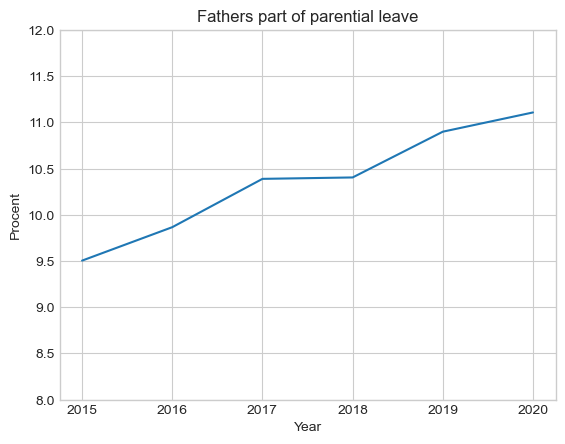

In [186]:
# a. Copy the dataframe 'Mother_all'
Father_part = Mother_all.copy()
# b. Left merge 'Father_part' and 'Father_all' on TID 
Father_part = pd.merge(Father_part, Father_all, how = 'left', on = 'TID')
# c. Rename the columns 
Father_part.columns = ['TID', 'mother', 'father']
# d. Find the father's part 
Father_part['INDHOLD'] = Father_part['father']/(Father_part['father'] + Father_part['mother'])*100

# e. Define figure and ax 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# f. Plot father's part 
Father_part.plot(x = 'TID', y = 'INDHOLD', ax=ax)
# g. Set title, label, y-axis limits and removes the legend
ax.set_title('Fathers part of parential leave')
ax.set_ylabel('Procent')
ax.set_xlabel('Year')
ax.set_ylim(8, 12)
ax.legend().remove()

From the above table it is seen that father's share of parential is increasing from 2015 to 2020. 

Next, we want to see how parential leave distribute when education is included. To do so we set the other parent's education level constant and we cut the data such that it contains the education levels for the father, TID and INDHOLD. 

In [210]:
# a. Cut the data for the father such that the mother's education is constant 
Father_educ = barsel_true[barsel_true['MORUD'] == 'All mothers, regardless of education']
# b. Remove variables 
Father_educ = Father_educ[(Father_educ['TAL'] != 'Number of couples') 
                           & (Father_educ['TAL'] != 'Mother - days on parental leave (benefits) after birth on average') 
                           & (Father_educ['TAL'] != 'Mother - days on parental leave (benefits) before birth on average')
                           & (Father_educ['FARUD'] != 'All fathers, regardless of education')]
# c. Cut data futher 
Father_educ = Father_educ[['FARUD', 'TID', 'INDHOLD']]
# d. Rename the education variables
Father_educ['FARUD'] = Father_educ['FARUD'].str.replace('Father ', '').str.title()

# e. Cut the data for the father such that the father's education is constant 
Mother_educ = barsel_true[barsel_true['FARUD'] == 'All fathers, regardless of education']
# f. Remove variables 
Mother_educ = Mother_educ[(Mother_educ['TAL'] != 'Number of couples') 
                           & (Mother_educ['TAL'] != 'Father - days on parental leave (benefits) after birth on average') 
                           & (Mother_educ['TAL'] != 'Mother - days on parental leave (benefits) before birth on average') 
                           & (Mother_educ['MORUD'] != 'All mothers, regardless of education')]
# g. Cut data futher                            
Mother_educ = Mother_educ[['MORUD', 'TID', 'INDHOLD']]
# h. Rename the education variables
Mother_educ['MORUD'] = Mother_educ['MORUD'].str.replace('Mother ', '').str.title()
Mother_educ['MORUD'] = Mother_educ['MORUD'].str.replace('Tertirary', 'Tertiary').str.title()

We want to plot the two plots. 

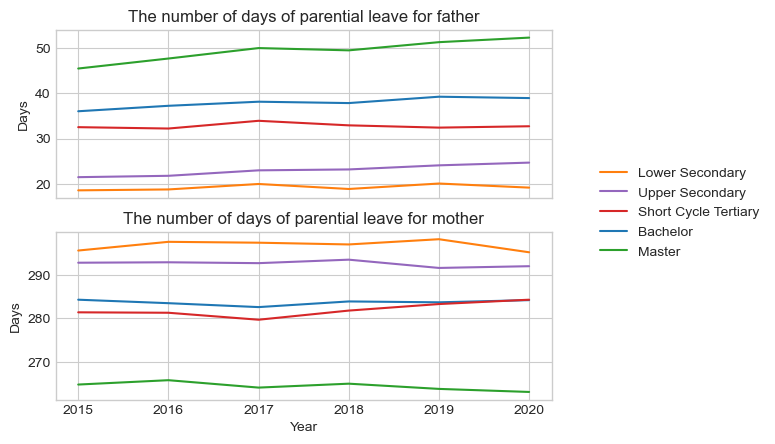

In [211]:
# a. Define the fig 
fig = plt.figure()

# b. Define ax to be the first of the two subplots 
ax = fig.add_subplot(2,1,1)
# c. Extract the name of each education and plot for each for father's education 
for label, group in Father_educ.groupby(['FARUD']):
    group.plot(x='TID', y='INDHOLD', ax=ax, style='-', label=label)
# d. Add labels, title and legend 
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_ylabel('Days')
ax.set_title('The number of days of parential leave for father');
ax.legend().remove()

# e. Define ax to be the second of the two subplots 
ax1 = fig.add_subplot(2,1,2)
# f. Extract the name of each education and plot for each for mother's education 
for label, group in Mother_educ.groupby(['MORUD']):
    group.plot(x='TID', y='INDHOLD', ax=ax1, style='-', label=label)
# g. Add labels, title and legend 
ax1.set_xlabel('Year')
ax1.set_ylabel('Days')
ax1.set_title('The number of days of parential leave for mother');
ax1.legend().remove()

# h. Create a single legend for both subplots 
handles, labels = ax.get_legend_handles_labels()
order = ['Lower Secondary', 'Upper Secondary', 'Short Cycle Tertiary', 'Bachelor', 'Master']
handles = [handles[labels.index(label)] for label in order]
labels = order
fig.legend(handles, labels, loc='center', bbox_to_anchor=(1.1,0.5))

The first above figure Figure shows that the father's number of maternity days is dependent on education level. It can be seen that fathers with lower secondary take the least leave with an average of approximately 20 days. This has almostremained unchanged throughout the observation period. In contrast to this, fathers with a master are seen, where the number of maternity days has increased from around 45 days in 2015 to around 52 days in 2020. Between these two extremes are upper secondary, short cycle tertiary and bachelor, where the number of days increases in line with the level of education.

It is not only fathers' allocation that depends on education level - the same applies to mothers. The second figure shows the mother's maternity leave days divided by education. Here it appears that mothers with lower secondary take the most maternity leave with around 295 days, which is approximately constant from 2015 to 2020. Mothers with upper secondary are just behind with around 292 days. In contrast to father, bachelor is slightly higher than short cycle tertiary in 2015, while they meet at around 285 days in 2020. Master level is seen a bit lower, at around 265 days.

We want to look futher into how the education level of each parent affects the father's share of the parential leave.
The following code prepares the data.

In [253]:
# a. Cut the data to mother's and father's education level in 2020 
Father_part_educ_1 = barsel_true[(barsel_true['FARUD'] != 'All fathers, regardless of education') 
                               & (barsel_true['MORUD'] != 'All mothers, regardless of education') 
                               & (barsel_true['TAL'] != 'Number of couples')
                               & (barsel_true['TAL'] != 'Mother - days on parental leave (benefits) before birth on average')
                               & (barsel_true['TID'] == 2020)]
# b. Cut the number of columns  
Father_part_educ_1 = Father_part_educ_1[['TAL', 'MORUD', 'FARUD', 'INDHOLD']]
# c. Rename the TAL column by using split and extract the first object 
Father_part_educ_1['TAL'] = Father_part_educ_1['TAL'].str.split(' ').str[0]
# d. Rename the MORUD and FARUD columns 
Father_part_educ_1['MORUD'] = Father_part_educ_1['MORUD'].str.replace('Mother ', '').str.title()
Father_part_educ_1['MORUD'] = Father_part_educ_1['MORUD'].str.replace('Tertirary', 'Tertiary').str.title()
Father_part_educ_1['FARUD'] = Father_part_educ_1['FARUD'].str.replace('Father ', '').str.title()
# e. Split the data into dataframe for mother and father 
Father_part_educ_1_m = Father_part_educ_1[Father_part_educ_1['TAL'] == 'Mother']
Father_part_educ_1_f = Father_part_educ_1[Father_part_educ_1['TAL'] == 'Father']
# f. Merge the Father_part_educ_1_m and Father_part_educ_1_f on MORUD and FARUD 
Father_part_educ_1 = pd.merge(Father_part_educ_1_m, Father_part_educ_1_f, on = ['MORUD', 'FARUD'], how = 'left')
# g. Cut the number of columns 
Father_part_educ_1 = Father_part_educ_1[['MORUD', 'FARUD', 'INDHOLD_x', 'INDHOLD_y']]
# h. Rename the columns 
Father_part_educ_1.columns = ['MORUD', 'FARUD', 'mother', 'father']

Then we present the conditional share of parential leave for the father. First in percent: 

In [256]:
Father_part_educ_1['FS'] = Father_part_educ['father']/(Father_part_educ['father'] + Father_part_educ['mother'])*100
Father_part_educ_1['FS'] = Father_part_educ_1['FS'].round(1)
Father_part_educ_2020_pivot_procent = Father_part_educ_1.pivot_table(index='MORUD', columns='FARUD', values='FS')
Father_part_educ_2020_pivot_procent = Father_part_educ_2020_pivot_procent.reindex(['Lower Secondary', 'Upper Secondary', 'Short Cycle Tertiary', 'Bachelor', 'Master'], axis=1)
Father_part_educ_2020_pivot_procent = Father_part_educ_2020_pivot_procent.reindex(['Lower Secondary', 'Upper Secondary', 'Short Cycle Tertiary', 'Bachelor', 'Master'])
print('Fathers share of the parential leave depending on education level in %')
Father_part_educ_2020_pivot_procent


Fathers share of the parential leave depending on education level in %


FARUD,Lower Secondary,Upper Secondary,Short Cycle Tertiary,Bachelor,Master
MORUD,,,,,
Lower Secondary,5.9,6.8,9.9,10.9,13.3
Upper Secondary,6.0,6.8,10.0,10.9,13.4
Short Cycle Tertiary,6.2,7.1,10.4,11.3,13.9
Bachelor,6.1,7.0,10.3,11.2,13.8
Master,6.6,7.5,10.9,12.0,14.6


Then we see it in days:

In [257]:
Father_part_educ_2020_pivot_days = Father_part_educ_1.pivot_table(index='MORUD', columns='FARUD', values='father')
Father_part_educ_2020_pivot_days = Father_part_educ_2020_pivot_days.reindex(['Lower Secondary', 'Upper Secondary', 'Short Cycle Tertiary', 'Bachelor', 'Master'], axis=1)
Father_part_educ_2020_pivot_days = Father_part_educ_2020_pivot_days.reindex(['Lower Secondary', 'Upper Secondary', 'Short Cycle Tertiary', 'Bachelor', 'Master'])
print('Fathers share of the parential leave depending on education level in days')
Father_part_educ_2020_pivot_days

Fathers share of the parential leave depending on education level in days


FARUD,Lower Secondary,Upper Secondary,Short Cycle Tertiary,Bachelor,Master
MORUD,,,,,
Lower Secondary,14.5,19.1,20.5,21.8,38.1
Upper Secondary,17.5,21.3,25.2,31.0,36.0
Short Cycle Tertiary,17.8,26.0,29.5,33.6,37.1
Bachelor,21.4,25.4,33.0,36.3,43.3
Master,31.3,35.4,42.2,47.9,58.1


The tables shows that the father's share of maternity days either weakens or increases depending on the mother's education. If, for example, both mother and father have lower secondary education, the father only takes 14.5 days of maternity leave, which corresponds to 5% of the total maternity leave.

If it is still considered that the mother has lower secondary education, a father with a master spends almost twice as many days on maternity leave as a father with a bachelor. The overall average seen in the second figure lies between these two levels of education. Conversely, if we look at mothers with a master, it appears that only fathers with lower secondary are below the average from the second figure with 31.3 days. The highest proportion is found where both parents have a master, then the father takes 14.6% of the maternity leave. Thus, there is a 8.7%-point difference between the smallest and largest share.